In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
#np.uint8(22)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [30]:
def mincelfun(inarr, params = 3):
    """
    The function takes a timeslice of the array and calculates of proportions of each neighbour in Moore neighbourhood.
    """
    retprob = np.zeros(params)
    totsum = 0
    for rowarr in inarr:
        for val in rowarr:
            totsum += val[1] # Increases the total sum of cells that have some state
            try:
                retprob[int(val[0])] += float(val[1]) # Uses value to index type of cell and increase value in prob array.
            except:
                print(rowarr)
    if (totsum == 0): # Is this correct? totsum is only 0 if the function is passed an empty matrix. 
        retprob = np.zeros(params)
        retprob[0] = 1
        return retprob
    return retprob / float(totsum)

def CA_city(init_mat, moore_n = 1, params = 3, debug = False):
    """
    Loops through each cell and calculates its prob of changing state, then changes the state randomly.
    """
    # Assumes initmat is of shape N,N,2 
    init_dimx, init_dimy, init_pars = np.shape(init_mat)
    
    workgrid = np.zeros((init_dimx + 2 * moore_n, init_dimy + 2 * moore_n, init_pars))
    retgrid = init_mat.copy()
    workgrid[moore_n:-moore_n, moore_n:-moore_n] = init_mat
    # Loops through the matrix dimensions, calls mincelfun() to find the values of neighbour cells. 
    for i,rowarr in enumerate(init_mat):
        for j,val in enumerate(rowarr):
            probs = mincelfun(workgrid[i:i+1 + 2*moore_n,j:j+1+2*moore_n], params = 3)
            increase_param = np.random.choice(list(range(params)), 1, p = probs)
            # if/else checks which value was randomly selected in previous line and updates matrix accordingly.
            if increase_param == 0:
                continue
            elif increase_param == workgrid[i+moore_n, j+moore_n, 0]:
                retgrid[i,j,1] += 1
            else:
                retgrid[i,j] = [increase_param,1]
    return retgrid


def init_grid(N, params, init_housing_nr, init_type):
    """
    The function creates the initial state of the matrix and sets its values.
    Takes the dimensions of the grid and parameters as arguments and returns initial condition of matrix.
    INPUT: N - Grid size/dimension, init_housing_nr - initial cells that are housing, init_type - "random" or "deterministic"
    OUTPUT: initial grid is returned
    """
    assert init_housing_nr > 0
    assert init_type in ['random', 'center']
    
    retgrid = np.zeros((2,N,N))
    if init_type == "center": # sets center of grid as initial cell with housing
        center = math.floor(N/2) # finds the center of the grid
        retgrid[0,center,center] = 1
    elif init_type == "random": # sets several cells as housing in the initial grid.
        init_xy = np.random.randint(0, N, [init_housing_nr,2])
        for i in range(init_housing_nr): # loops through random numbers and sets cells as housing.
            retgrid[0,init_xy[i][0], init_xy[i][1]] = 1
    return retgrid

In [53]:
dimensions = 40
time = 20
solution_dev = np.empty((time, 2, dimensions, dimensions))
init_city = init_grid(dimensions,2,5,'random')

solution_dev[0] = init_city
#solution_dev[1] = CA_city(solution_dev[0])

for step in range(1,time):
    solution_dev[step] = CA_city(solution_dev[step-1])
    

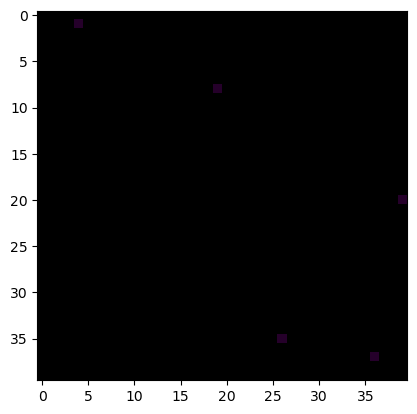

In [54]:
plt.imshow(solution_dev[-1][0], cmap = 'nipy_spectral', vmin = 0, vmax = 60)

In [72]:
# Hoshen-Kopelman Clustering algorithm
#https://en.wikipedia.org/wiki/Hoshen–Kopelman_algorithm

In [127]:
def clustering(m):
    """ Algorithm for finding clusters and labeling them. 
    INPUT: Matrix m with occupied 1 and unoccupied 0"""
    dim = m.shape[0]
    largest_label = 0;
    label = np.zeros([dim, dim])
    for x in range(dim):
        for y in range(dim):
            above = m[x-1, y]
            left = m[x, y-1]
            # For the boundary conditions, set above and left to zero.
            if x == 0:
                above = 0
            if y == 0:
                left = 0
            # Assign cluster IDs according to neighbours   
            if m[x,y] == 1:
                if above == 0 and left == 0: # no neighbors, new cluster id
                    largest_label += 1
                    label[x,y] = largest_label
                elif above == 1 and left == 0: # cluster extends from above, change id
                    label[x,y] = label[x-1,y]
                elif above == 0 and left == 1: # cluster extends from left, change id
                    label[x,y] = label[x,y-1]
                elif above == 1 and left == 1: # both belong to cluster, make a union
                    m, label = cluster_union(m, label, x, y)
                    
    return label
            
def cluster_union(m, label, x, y):
    """
    Union the two clusters and labels both clusters the same
    """
    if label[x-1,y] == label[x,y-1]:
        label[x,y] = label[x-1,y]
        return m, label
    else: # else different clusters so rename one
        new_id, old_id = np.min([label[x-1,y], label[x,y-1]]), np.max([label[x-1,y], label[x,y-1]])
        label[x,y] = new_id # set label of current x,y
        label[label == old_id] = new_id # change all old IDs to the new one
    return m, label

m = np.random.randint(0,2, (10,10), dtype=int)
print(m)
clustering(m)

[[1 0 1 0 1 1 1 0 1 1]
 [1 0 1 1 1 0 1 1 1 1]
 [1 1 1 1 0 1 0 1 1 1]
 [1 1 1 1 0 1 1 1 1 0]
 [1 0 1 0 0 0 1 1 1 1]
 [0 1 0 1 1 0 1 1 1 0]
 [1 0 0 0 0 1 1 0 0 0]
 [0 1 0 0 1 1 0 0 1 0]
 [1 0 1 1 0 0 1 1 1 0]
 [1 0 1 0 1 1 0 0 1 0]]


array([[ 1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
       [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.],
       [ 1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
       [ 0.,  6.,  0.,  7.,  7.,  0.,  1.,  1.,  1.,  0.],
       [ 8.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.,  1.,  1.,  0.,  0., 12.,  0.],
       [13.,  0., 14., 14.,  0.,  0., 12., 12., 12.,  0.],
       [13.,  0., 14.,  0., 16., 16.,  0.,  0., 12.,  0.]])

In [ ]:
# Fractal Dimension from occupancy rate and radius from centre.
from scipy.optimize import least_squares


def fractal_dimension(m, centre, radius):
    """
    Calculates the fractal dimension of the occupancy for each radius
    """
    dim = m.shape[0] # get the array dimension
    distance = np.zeros([dim,dim])
    radius = np.zeros(10,2)
    radius[:,0] = range(10) # sets the range to loop over for occupancy
    for i in range(dim):
        for j in range(dim):
            distance[i,j] = np.sqrt((centre[0] - i) ** 2 + (centre[1] - j) ** 2)
    # logic is to filter spots within distance, then multiply with m matrix to find spots where there are occupants
    # assuming empty spots are marked with zero and sum the spots within raidus and with occupants.
    for r in radius[:,0]: 
        current_distance = np.where(distance < radius, 1, 0)
        radius[r,1] = (current_distance * m).sum()
    
    fractal_d = least_squares(np.log(radius[:,1]), np.log(radius[:,0])).x[1] # area is y axis and radius on x, returns coef
    return fractal_d